# Prosjekt 2: Introduksjon til maskinlæring
## Frederick Nilsen, Mia Rødde, Sara Abnar

**Introduksjon**

Målet med dette prosjektet var å benytte maskinlæringens delområde dyplæring til å utføre en binær klassifisering av punkter i planet og ulike bilder. Det ble satt opp en modell som anvendte en serie av transformasjoner på input-dataen, hvor hver transformasjon var assosiert med et sett av parametere. Disse parameterene ble uttrykt med $U = [(W_{k}, b_{k})^{K-1}_{k=0}, \omega, \mu]$, hvor $W_{k}$ er en $d$ x $d$- matrise og $b_{k}$ er en $d$-vektor for hver $k$. Modellen fikk, som input-data, $I$ antall treningsbilder med dimensjon $d$. Transformasjonen kunne da skrives som $Y_{k+1} = Y_{k} + h\sigma(W_{k}Y_{k} + b_{k}$, hvor $Y_{0}$ ble en $d$ x $I$-matrise som inneholdt alle bildene før transformasjonen. 

Etter den siste transformasjonen ble resultatet projisert ned på en skalar, noe som resulterte i vektoren $Z$. Så ble kostfunksjonen, $J = \frac{1}{2}\sum_{i = 1}^{I}\mid(Z_{i} - c_{i})\mid^2$, brukt til å regne ut avviket fra den riktige klassifiseringen. Her er $c_i$ korrekt klassifisering tilhørende bilde $i$. Videre ble parameterne i $U$ optimalisert ved å beregne gradienten til $J(U)$ hvor $U$ ble forandret for hver iterasjon. Alt dette dannet basen for hovedalgoritmen som ble gjentatt mange ganger, som en del av treningsfasen. 

Deretter ble vektene som var blitt funnet implementert, i det et nytt sett med bilder ble kjørt gjennom den samme modellen. Resultatet ble så framstilt som en presentasjon av hvor mange riktige klassifikasjoner modellen får, sammenlignet med fasit.

### Initialisering og generell algoritme

In [1]:
## IMPORTS

import numpy as np #Numpy-biblioteket
import matplotlib.pyplot as plt #Generell plotting
from loader import * #Utdelt kode for innlastning av MNIST-data
from plotting import * #Plottingfunksjoner fra utdelt kode
from spirals import get_data_spiral_2d #Spiralgenererende funksjon fra utdelt kode
import pickle # Lar oss lagre en binær dump av vekter fra trening

In [2]:
## GLOBAL CONSTS AND DEFINITIONS

sigma = lambda x : np.tanh(x)         # Activation function
eta = lambda x : 0.5*(1+np.tanh(x/2)) # Scalar function     
eta_ddx = lambda x :  0.25*(1-np.tanh(x/2)*np.tanh(x/2)) # Derivative of eta
sigma_ddx = lambda x: 1-(np.tanh(x))**2 # Derivative of sigma

##### Global consts for the first dataset
K = 10 # Antall lag
d = 2 # Antall dimensjoner
tau = 0.1 # Læringsparameter, brukes i "plain vanilla"-algoritmen, [0.01,0.1]
np.random.seed(0) #Definerer vårt seed, gjør det enklere å debugge
Y0, C = get_data_spiral_2d(200) #Default n=200
I = Y0.shape[1]

np.random.seed(0)
W = np.random.randn(K,d,d)
np.random.seed(0)
b = np.random.randn(K,d,1)     #W,b,mu og w initieres med tilfeldige verdier 
np.random.seed(0)
mu = np.random.randn()
np.random.seed(0)
w = np.random.randn(d,1)
h = 0.1 # Steglengde

Ulst = [W, b, w, mu] # Python-liste bestående av vektobjektene, brukes bl.a Adam-metoden

In [3]:
## Funksjoner

'''
saveU dumper binærdata av vektene (Ulst), til tekstfil.
Dette muliggjør å opphente vektene for testing av presisjon uten å måtte trene algoritmen på nytt
loadU laster inn Ulst fra en innlastet fil. Antatt at fil eksisterer og ikke kaster exception
'''
def saveU(dataset="spirals"):
    with open('weights-' + dataset + '.txt', 'wb') as f:
        pickle.dump(Ulst,f)

def loadU(dataset="spirals"):
    with open('weights' + dataset + '.txt','r') as f:
        pickle.load(f)
'''
Labels, C, er en array av bools. Her har vi antatt at true er rød og false er blå,
og tilordnet fargene som brukes til plotting. Bruker list comprehension
'''
def getColorFromLabel(C):
    colorLst = []
    colorLst.append('r' if value else 'b' for value in C)
    return colorLst
C_colors = getColorFromLabel(C) #Fargeliste til plotting for første datasett


'''
YK(W,b,Ystart=Y0)
Tar inn vektene W og b eventuelt en egendefinert startverdi for Y. Som standard brukes Y0 fra spiraloppgaven,
men dersom spesifisert fungerer den tilsvarende for MNIST-oppgaven.
Funksjonen tilsvarer likning (1) i oppgavetekst.
'''
def YK(W, b, Ystart=Y0):
    #tom Y-matrise, 3-dimensjonalt numpy-array
    Ym = np.zeros((K+1,d,I))
    Ym[0,:,:] = np.copy(Ystart)
    k=0
    while k < K:
        Ym[k+1] = Ym[k] + h*sigma(W[k]@Ym[k] + b[k])
        k+=1
    return Ym

'''
getGradients
Tar inn lag K, samt vektene, C og Y og regner ut alle gradienter som beskrevet i prosjektbeskrivelsen og returnerer dem.
Store deler av koden er en implementasjon av henholdsvis likning (5), (6), (7), (8) og (9)
Også getGradients tar utgangspunkt i data fra spiraloppgave med mindre annet er spesifisert.
Alle arrays deklareres med np.zeros(), og fylles deretter opp som beskrevet i oppgaveteksten.
'''
def getGradients(K, W, b, w, mu, c=C, Ystart=Y0):
    Y_all = YK(W,b, Ystart) #Kan vi droppe denne plis? Og heller bruke YK_list som er global?
    lastY = Y_all[-1,:,:]
    P = np.zeros((Y_all.shape)) #Initalisering
    P[K,:,:] = w@np.transpose((Zf(w,mu, lastY)-c)*eta_ddx(np.transpose(lastY)@w+mu))  #(7)
    
    dJdMU = eta_ddx(np.transpose(np.transpose(lastY)@w+mu))@(Zf(w,mu, lastY)-c) #(5)
    dJdw = lastY@((Zf(w,mu, lastY)-c)*eta_ddx(np.transpose(lastY)@w+mu))  #(6)
    for k in range(K,0,-1):
        P[k-1,:,:] = P[k,:,:]+h*np.transpose(W[k-1,:,:])@(sigma_ddx(W[k-1,:,:]@Y_all[k-1,:,:]+b[k-1,:,:])*P[k,:,:])  #(8) 
    dJdWk = np.zeros((K,d,d)) #Init
    dJdBk = np.zeros((K,d,1)) #Init
    
    for k in range(0,K):
        dJdWk[k] = h*(P[k+1]*sigma_ddx(W[k,:,:]@Y_all[k,:,:]+b[k,:,:]))@np.transpose(Y_all[k,:,:])  #(9)
        dJdBk[k] = h*(P[k+1]*sigma_ddx(W[k,:,:]@Y_all[k,:,:]+b[k,:,:]))@np.ones((I,1)) #(10)
    return dJdWk, dJdBk, dJdw, dJdMU


'''
AdamAlg
Tar inn liste av vekter (Ulst), Y0 og C fra importert data samt m og v.
Variablene m og v bestemmes av AdamAlg, og er en liste med samme lengde som Ulst.
Counter er en global variabel som følger med på antall iterasjoner og brukes i potensuttrykket til mhat og vhat.

gradLst består av en liste av gradientobjektene fra getGradients(), og vi kjører deretter en for-løkke
for å oppdatere vektene for alle gradienter.
Funksjonen returnerer Ulst, en liste over oppdaterte vekter.
Funksjonen returnerer også m og v da neste kall på funksjonen avhenger av m- og v-verdiene fra forrige beregning.
'''
def AdamAlg(Ulst, m, v, c=C, Ystart=Y0):
    beta1 = 0.9
    beta2 = 0.999
    alpha = 0.01
    epsilon = 1e-8
    W, b, w, mu = Ulst
    gradLst = [x for x in getGradients(K, W, b, w, mu, c, Ystart)] #Syntaks tvinger data til liste og ikke tuple
    for i in range(len(gradLst)):
        g = gradLst[i]
        m[i] = beta1*m[i]+(1-beta1)*g
        v[i] = beta2*v[i]+(1-beta2)*(g*g)
        mhat = m[i]/(1-beta1**(counter))
        vhat = v[i]/(1-beta2**(counter))
        Ulst[i] -= alpha*mhat/(np.sqrt(vhat)+epsilon)
    return Ulst, m, v

### Testproblem 1 - punkter i planet

In [4]:
YK_list = YK(W,b) #Denne må være identisk med Y_all i getGradients >:(
lastY = YK_list[-1,:,:]

Zf = lambda w,mu,finalY=lastY : eta(np.transpose(finalY)@w +mu) #(2)
Jf = lambda Z=Zf(w,mu), ce=C : 1/2*np.linalg.norm(Z-ce)**2 #(3) Kostnadsfunksjon

In [5]:
#Hovedalgoritmecelle
counter = 1 

#initializing list
m = [0 for x in range(len(Ulst))]
v = [0 for x in range(len(Ulst))]

#for AdamAlg
for i in range(1,10001): #"while not converged" gjort om til for med angitt antall iterasjoner
    Ulst, m, v = AdamAlg(Ulst, m, v)
    counter +=1 

W, b, w, mu = Ulst
saveU()

Ved testing av vektene med "Plain vanilla" fikk vi en kostnadsfunksjon $J \approx 0.04$. Vektene fra Adam-metoden ga derimot en $J\approx 0.01$. Vi valgte derfor å bruke Adam-optimeringen, og grafene er presentert nedenfor. Disse grafene viser utviklingen av punktene per lag for totalt $K=10$ lag. Man ser at det siste laget har klart å separere punktene sammenliknet med det første laget, slik at en linje kan trekkes mellom de blå og røde punktene.

0.17745877840627147


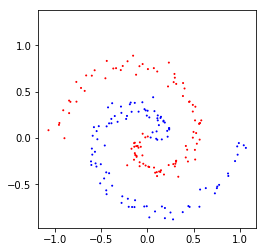

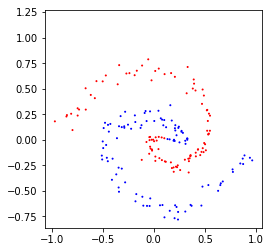

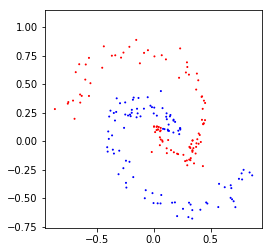

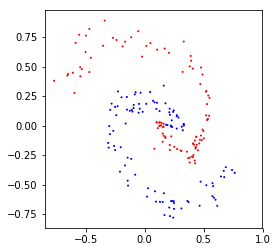

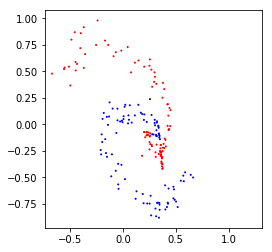

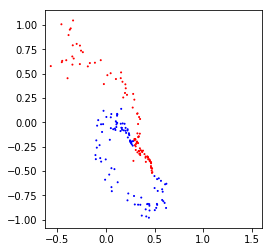

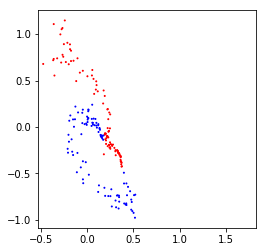

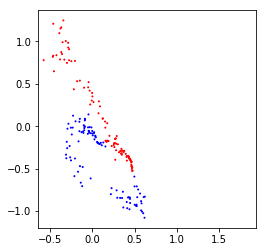

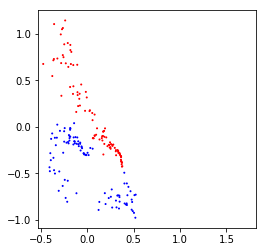

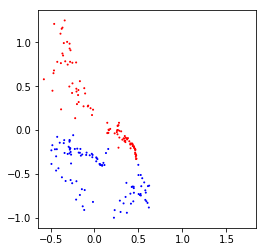

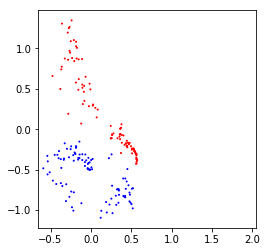

In [6]:
'''
Test-celle for spiraldata
Denne cellen genererer et nytt sett med data for testing, og bruker vektene fra treningen til å beregne Z/Y
Deretter plottes punktene for hvert lag.
'''
testY, testC = get_data_spiral_2d(200) 
Ulst = loadU() #laster inn Ulst fra fil
W,b,w,mu = Ulst 
trainedY = YK(W, b, testY)
lastY = trainedY[-1,:,:]
J = Jf(Zf(w,mu, lastY), testC)
trainedZ = Zf(w,mu,lastY)
print("h: ", h, "J: ", J)

plot_progression(trainedY, testC)

In [7]:
lowerBoundary_setTrueZ = [0.65, 0.75, 0.85, 0.95, 0.99, 1]
upperBoundary_setFalseZ = [0, 0.01, 0.05, 0.15, 0.25, 0.35]

'''
checkResults
Tilleggsfunksjon for å systematisere resultatene fra første datsett (spirals)
Beregner Z og J med opptrente vekter og presenterer resultater.
Ser deretter, basert på ulike presisjonsterskeler (lowerBoundary_setTrueZ) om algoritmen har tilordnet rikitg label opp mot C
I funksjonen brukes list comprehension, men er tilsvarende en "countif"-funksjon,
Teller altså antall True og tall rundt 1, som i spirals vil tilsvare blå farge, og i MNIST er tallet 7/andre digit
'''

def checkResults(n=I):
    numTrue=0
    numFalse=0
    numTrue_J = 0
    numFalse_J = 0
    print("h: ", h)
    print("J_new:", J)
    numTrue = sum(1 if testC[i][0] else 0 for i in range(n))
    numFalse = sum(0 if testC[i][0] else 1 for i in range(n))
    print("Antall true:", numTrue, "\nAntall false: ", numFalse, "\n")
    print("Lower boundary \t Antall true i følge J     Success rate[%]")
    for lowerBound in lowerBoundary_setTrueZ:
        numTrue_J = sum(1 if trainedZ[i][0] >=lowerBound else 0 for i in range(n))
        success_rate_true = round((100-abs(numTrue_J-numTrue))/numTrue*100, 2)
        print(lowerBound, numTrue_J, success_rate_true, sep="\t\t\t")
    print("\nUpper boundary \t Antall false i følge J     Success rate[%]")
    for upperBound in upperBoundary_setFalseZ:
        numFalse_J = sum(1 if trainedZ[i][0] <= upperBound else 0 for i in range(n))   #Gives 1 for z <= [0, 0.01, ...]
        success_rate_false = round((100-abs(numFalse_J-numFalse))/numFalse*100, 2)
        print(upperBound, numFalse_J, success_rate_false, sep="\t\t\t")
    

Beregningene viser at en steglengde på $h=0.1$ gir perfekte samsvar mellom punktenes faktiske verdi og klassifiseringen av punktene for de trente punktene. Ved å kjøre funksjonen på et sett med testpunkter, får vi ikke like gode samsvar, men verdien av $J$ er nokså nærme 0, og det kan konkluderes med at klassifiseringen fungerer greit.

In [8]:
checkResults() 

J_new: 2.9685578797102754
Antall true: 100
Lower boundary 	 Antall true i følge J 		 Success rate[%]
0.65			96			96.0
0.75			96			96.0
0.85			96			96.0
0.95			95			95.0
0.99			85			85.0


### Testproblem 2 - Siffergjenkjenning

In [9]:
#INITIALISING LIST, PART 2
K = 10
Y0pic, C_pic = get_dataset("testing")
d = Y0pic.shape[0]
I = Y0pic.shape[1]

np.random.seed(0)
W = np.random.randn(K,d,d)
np.random.seed(0)
b = np.random.randn(K,d,1)     #Reinitialiserer vektene til tilfeldige verdier
np.random.seed(0) 
mu = np.random.randn()
np.random.seed(0)
w = np.random.randn(d,1)
h = 0.1

Ulst = [W, b, w, mu]

In [10]:
'''Treningscelle for testsett 2'''
counter = 1

#initializing list
m = [0 for x in range(len(Ulst))]
v = [0 for x in range(len(Ulst))]

#AdamAlg
for i in range(1,501): #"while not converged" gjort om til for med angitt antall iterasjoner
    Ulst, m, v = AdamAlg(Ulst, m, v, C_pic, Y0pic)
    print(counter)
    counter +=1 #Brukes i AdamAlg

saveU("MNIST")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [11]:
'''Test-celle for MNIST'''
Ulst = loadU("MNIST")
W,b,w,mu = Ulst 
testpic, testCp = get_dataset("testing")
I = testpic.shape[1]
d = testpic.shape[0]
trainedPic = YK(W, b, testpic)
lastYPic = trainedPic[K,:,:]

trainedZ = Zf(w, mu, lastYPic)


In [12]:

'''
checkResultsPic fungerer på samme måte som checkResults
'''
lowerBoundary_setTrueZ = [0.65, 0.75, 0.85, 0.95, 0.99, 1.00]

def checkResultsPic(n=I): 
    J_new=Jf(trainedZ, testCp)
    numTrue_J = np.array([]) 
    print("h: ", h)
    print("J_new:", J_new)
    numTrue = sum(1 if testCp[i][0] else 0 for i in range(n))
    print("Antall true:", numTrue)
    print("Lower boundary \t Antall true i følge J \t   Success rate[%]")
    for lowerBound in lowerBoundary_setTrueZ:
        numTrue_J = sum(1 if trainedZ[i][0] >=lowerBound else 0 for i in range(n))
        success_rate = round((numTrue_J-2*abs(numTrue_J-numTrue))/numTrue*100, 2)
        print(lowerBound, numTrue_J, success_rate, sep="\t\t\t")

checkResultsPic()


J_new: 47.499999621576706
Antall true: 1032
Lower boundary 	 Antall true i følge J 		 Success rate[%]
0.65			1029			99.7093
0.75			1029			99.7093
0.85			1029			99.7093
0.95			1029			99.7093
0.99			1029			99.7093
1.0			1027			99.5155


Ved klassifikeringen av om et bilde inneholder et tall eller ikke, måtte noen av parameterene fra forrige oppgave modifiseres. Som i oppgaven over, ønsket vi å finne en optimal $h$ for å minimere $J$. Følgende tabell gir en oversikt over fire utvalgte verdier for $h$ og tilsvarende verdier for $J$,

h=0.25      J=521.0      success rate = 1.74%

h=0.10      J=117.54204  success rate = 103.88%

h=0.80      J=521.9999   success rate = 1.94%

h=0.08      J=515.5      success rate = 0.1%

h=0.11      J=515.0      success rate = 0.58%

hvor suksess raten er for en nedre begrensning $lowerBoundary = 0.80$. Vi har dermed valgt å bruke steglengden $h=0.1$ i dette programmet vårt. For treningsbildene fikk den oppnådde kostfunksjonen en verdi på $J\approx 117.54204$, som er en nokså høy verdi. Vi er usikre på hvorfor denne ble så høy, også tatt i betraktning at suksessraten ble ganske nær $100\%$.

**NB:** Vi ser at koden vår nylig har blitt endret uten intensjon. Vi har derimot ikke tid til å se over hvor feilen ligger. Dermed vil noen (muligens alle) printede data ikke stemme overens med data vi har skrevet i Markdown cellene.